# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [21]:
# Add any additional import statements you need here
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/datascience/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/chandler/dropbox/teaching/repos/ads-tm-api-scrape/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "/Users/datascience/Desktop/Text Mining/Sentiment_Analysis-main/positive-words.txt"
negative_words_file = "/Users/datascience/Desktop/Text Mining/Sentiment_Analysis-main/negative-words.txt"
tidy_text_file = "/Users/datascience/Desktop/Text Mining/Sentiment_Analysis-main/tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [2]:
# Read in the lyrics data

# Read in the lyrics data
lyrics_data = pd.DataFrame(columns=['artist','filename','lyrics'])

for root, dirs, files in os.walk("/Users/datascience/Desktop/Text Mining/ads-tm-api-scrape/lyrics"):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), "r") as f:
                # split the file path to get the artist and song name
                artist,filename = os.path.join(root,file).split("/")[-2:]
                # store the file contents in the dataframe
                lyrics_data = pd.concat([lyrics_data,pd.DataFrame({'artist':artist, 'filename':filename, 'lyrics':f.read()},index=[0])],ignore_index=True)

lyrics_data['song'] = lyrics_data['lyrics'].str.extract('^"(.*?)"', expand=False)
lyrics_data['lyrics'] = lyrics_data['lyrics'].str.replace('^".*?"\n', '')
lyrics_data = lyrics_data[['artist', 'filename', 'song', 'lyrics']]



/var/folders/5b/b9cxhv4n4t90drzfsj1kdbx00000gp/T/ipykernel_81719/1622133744.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_data['lyrics'] = lyrics_data['lyrics'].str.replace('^".*?"\n', '')


In [11]:
lyrics_data

,artist,filename,song,lyrics
0,robyn,robyn_includemeout.txt,Include Me Out,\n\n\nIt is really very simple\nJust a single ...
1,robyn,robyn_electric.txt,Electric,\n\n\nElectric...\n\nIt's electric\nIt's a nat...
2,robyn,robyn_beach2k20.txt,Beach 2K20,\n\n\n(So you wanna go out?\nHow you gonna get...
3,robyn,robyn_lovekills.txt,Love Kills,\n\n\nIf you're looking for love\nGet a heart ...
4,robyn,robyn_timemachine.txt,Time Machine,"\n\n\nHey, what did I do?\nCan't believe the f..."
...,...,...,...,...
415,cher,cher_takeitfromtheboys.txt,Take It From The Boys,\n\n\nSo scared I never been\nToo hard to keep...
416,cher,cher_dreambaby.txt,Dream Baby,\n\n\nI found the boy for me\nHe's my dream ba...
417,cher,cher_pleasedonttellme.txt,Please Don't Tell Me,\n\n\nYa shook the override \nWhy'd I get this...
418,cher,cher_ihopeyoufindit.txt,I Hope You Find It,"\n\n\nThese clouds aren't going nowhere, darli..."


In [4]:
# Read in the twitter data
# Read in the twitter data
twitter_data = []

for root, dirs, files in os.walk("/Users/datascience/Desktop/Text Mining/ads-tm-api-scrape/twitter"):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), "r") as f:
                artist = file.split("_")[0]
                for line in f:
                    data = line.strip().split("\t")
                    if len(data)>6:
                      twitter_data.append({'artist':artist, 'screen_name':data[0], 'description':data[6]})

twitter_data = pd.DataFrame(twitter_data)

twitter_data['artist'] = twitter_data['artist'].replace('robynkonichiwa', 'robyn', regex=True)

In [5]:
twitter_data

,artist,screen_name,description
0,cher,screen_name,description
1,cher,horrormomy,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,cher,anju79990584,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,cher,gallionjenna,csu
4,cher,bcscomm,Writer @Washinformer @SpelmanCollege alumna #D...
...,...,...,...
2191120,robyn,jakegiles,"singer of songs, type 1 diabetic, tired $jakel..."
2191121,robyn,axelbluhme,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...
2191122,robyn,RayRayRay27,A year to change a life is still a year ✨😌
2191123,robyn,bhandberg,Head of Consumer - Mango. Made in Melbourne. R...


In [8]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.


# Read in positive words
with open('/Users/datascience/Desktop/Text Mining/Sentiment_Analysis-main/positive-words.txt', 'r', encoding='ISO-8859-1') as f:
    positive_words = [line.strip() for line in f]

# Read in negative words
with open('/Users/datascience/Desktop/Text Mining/Sentiment_Analysis-main/negative-words.txt', 'r', encoding='ISO-8859-1') as f:
    negative_words = [line.strip() for line in f]

# Read in tidytext sentiment
tidytext_sentiment = pd.read_csv('/Users/datascience/Desktop/Text Mining/Sentiment_Analysis-main/tidytext_sentiments.txt', sep='\t')

# Create dictionary of positive and negative words with scores
word_scores = {}
for word in positive_words:
    word_scores[word] = 1
for word in negative_words:
    word_scores[word] = -1

# Create dataframe of word scores
word_scores_df = pd.DataFrame(list(word_scores.items()), columns=['word', 'score'])

# Merge word scores with tidytext sentiment
tidytext_sentiment = pd.merge(tidytext_sentiment, word_scores_df, on='word', how='left')


In [9]:
# There are some words that are neither in the postive or negative word list and therefore get a score of NaN
tidytext_sentiment

,word,sentiment,lexicon,score
0,abandon,negative,nrc,NaN
1,abandoned,negative,nrc,NaN
2,abandonment,negative,nrc,NaN
3,abba,positive,nrc,NaN
4,abduction,negative,nrc,NaN
...,...,...,...,...
15128,win,positive,loughran,1.0
15129,winner,positive,loughran,1.0
15130,winners,positive,loughran,1.0
15131,winning,positive,loughran,1.0


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [13]:
# Filter to only include Robyn and Cher's songs
robyn_cher_data = lyrics_data[(lyrics_data['artist'] == 'robyn') | (lyrics_data['artist'] == 'cher')]

# Tokenize the lyrics of each song
robyn_cher_data['tokens'] = robyn_cher_data['lyrics'].apply(nltk.word_tokenize)

# Convert tokens to lowercase and remove any punctuation or special characters
robyn_cher_data['clean_tokens'] = robyn_cher_data['tokens'].apply(lambda x: [token.lower() for token in x if token.isalnum()])

# Calculate sentiment score for each song
robyn_cher_data['sentiment_score'] = robyn_cher_data['clean_tokens'].apply(lambda x: tidytext_sentiment[tidytext_sentiment['word'].isin(x)]['score'].sum())

# Print the resulting dataframe with the sentiment scores
print(robyn_cher_data[['artist', 'song', 'sentiment_score']])

    artist                   song  sentiment_score
0    robyn         Include Me Out              4.0
1    robyn               Electric             -8.0
2    robyn             Beach 2K20              6.0
3    robyn             Love Kills            -12.0
4    robyn           Time Machine            -10.0
..     ...                    ...              ...
415   cher  Take It From The Boys             -2.0
416   cher             Dream Baby              9.0
417   cher   Please Don't Tell Me             -5.0
418   cher     I Hope You Find It              0.0
419   cher          Classified 1A             -6.0

[420 rows x 3 columns]


In [16]:
# Which artist has the higher average sentiment per song?

# Group lyrics_data by artist
grouped = robyn_cher_data.groupby('artist')

# Calculate mean sentiment score for each artist
mean_sentiment = grouped['sentiment_score'].mean()

# Print mean sentiment score for each artist
print(mean_sentiment)

artist
cher    -1.246835
robyn   -1.221154
Name: sentiment_score, dtype: float64


In [20]:
# 3 highest and 3 lowest sentiments. 
# Group lyrics data by artist
grouped = robyn_cher_data.groupby('artist')

# Loop through groups (artists)
for artist, group in grouped:
    # Sort by sentiment score
    sorted_group = group.sort_values(by='sentiment_score', ascending=False)
    
    # Get top 3 and bottom 3 songs by sentiment score
    top_songs = sorted_group.head(3)
    bottom_songs = sorted_group.tail(3)
    
    # Print top 3 and bottom 3 songs with lyrics
    print(f"\nTop 3 songs with highest sentiment score for {artist}:\n")
    for index, row in top_songs.iterrows():
        print(f"{row['song']} by {row['artist']}")
        
    print(f"\nBottom 3 songs with lowest sentiment score for {artist}:\n")
    for index, row in bottom_songs.iterrows():
        print(f"{row['song']} by {row['artist']}")




Top 3 songs with highest sentiment score for cher:

Wasn't It Good by cher
She Loves To Hear The Music by cher
Perfection by cher

Bottom 3 songs with lowest sentiment score for cher:

Sisters Of Mercy by cher
All I Really Want To Do by cher
Our Lady Of San Francisco by cher

Top 3 songs with highest sentiment score for robyn:

Do You Really Want Me (Show Respect) by robyn
Baby Forgive Me by robyn
Who's That Girl by robyn

Bottom 3 songs with lowest sentiment score for robyn:

Lose Control by robyn
Still Your Girl by robyn
Criminal Intent by robyn


In [17]:
# 3 highest and 3 lowest sentiments. 
# Group lyrics data by artist
grouped = robyn_cher_data.groupby('artist')

# Loop through groups (artists)
for artist, group in grouped:
    # Sort by sentiment score
    sorted_group = group.sort_values(by='sentiment_score', ascending=False)
    
    # Get top 3 and bottom 3 songs by sentiment score
    top_songs = sorted_group.head(3)
    bottom_songs = sorted_group.tail(3)
    
    # Print top 3 and bottom 3 songs with lyrics
    print(f"\nTop 3 songs with highest sentiment score for {artist}:\n")
    for index, row in top_songs.iterrows():
        print(f"{row['song']} by {row['artist']}:\n{row['lyrics']}\n")
        
    print(f"\nBottom 3 songs with lowest sentiment score for {artist}:\n")
    for index, row in bottom_songs.iterrows():
        print(f"{row['song']} by {row['artist']}:\n{row['lyrics']}\n")



Top 3 songs with highest sentiment score for cher:

Wasn't It Good by cher:



Wasn't it good
The way that I touched you late last night
Wasn't it good again
In the morning's early light

Did you know when you closed
That bedroom door
I betcha didn't know exactly what
I had in store

Wasn't it good
When you felt it coming through you
Wasn't it good
That I knew just how to do you

Did you know you never had it
Like this before
I betcha didn't know
You'd be coming around
Back for more, more, more

Let's have a party
Love's pouring out of my soul
I'm your party hearty
And let the future take control

Just remember my darling
When there's time to spare
You'll be thinking about me
And our hot affair
Saying wasn't it good
Wasn't it good so good

Did you know you never had it
Like this before
And I betcha didn't know
You'd be coming around
Back for more, more, more

Let's have a party
Love's pouring out of my soul
I'm your party hearty
And let the future take control

Let's have a party
We'l

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Cher had an average sentiment of -1.24 and robyn had an average sentiment of -1.22. Therefore Robyn had the higher average sentiment per song.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: (Lyrics are located in the code block above)

Top 3 songs with highest sentiment score for cher:

- Wasn't It Good 
- She Loves To Hear The Music
- Perfection 

The first set of lyrics has a confident and sensual tone, which creates a positive sentiment. The second set of lyrics convey a mix of admiration and loneliness due to the woman's love for music. The third set of lyrics convey a sense of striving for perfection and success, but also disillusionment and loneliness, resulting in a positive sentiment due to recognition of the hard work and relatable experience.

Bottom 3 songs with lowest sentiment score for cher:

- Sisters Of Mercy 
- All I Really Want To Do 
- Our Lady Of San Francisco by cher

Cher's "Sisters of Mercy" expresses negativity towards religious institutions and individuals who use religion to justify harm, especially towards women and children. The song calls out the lack of mercy, grace, and faith among these people. On the other hand, "All I Really Want To Do" is a happy song about wanting to form a genuine friendship without any ulterior motives or competition."Our Lady of San Francisco" addresses the problem of homelessness and the lack of support for those in need. The lyrics show frustration with society's current state and a longing for change to help those struggling.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: (Lyrics are located in the code block above)

Top 3 songs with highest sentiment score for robyn:

- Do You Really Want Me (Show Respect) 
- Baby Forgive Me 
- Who's That Girl 

The first song emphasizes the importance of treating your partner with love, respect, and attention. It warns that without these things, you'll receive only hatred in return. The second song, "Baby Forgive Me," asks for forgiveness and another chance in a relationship. The third song, "Who's That Girl," challenges the traditional expectations of what it means to be a "good girl" and asks who the ideal girl is that men dream of.

Bottom 3 songs with lowest sentiment score for robyn:

- Lose Control 
- Still Your Girl 
- Criminal Intent 
Robyn's first song, "Lose Control," expresses frustration and discomfort when we can't control a situation or our emotions. The song's chorus repeats the line, "You don't like what you can't control," highlighting the negativity that arises from a lack of control. In contrast, Robyn's second song, "Still Your Girl," conveys loyalty and support towards a friend or partner. The singer promises to remain a steadfast companion through hardships and difficulties. The chorus repeats the line, "I'm still your girl," emphasizing the message of support and loyalty.Finally, Robyn's "Criminal Intent" challenges societal norms regarding sexuality. The lyrics suggest that engaging in sexual acts is not a crime, but rather a natural and enjoyable part of life. The chorus playfully repeats the phrase, "Somebody alert the authorities, I got criminal intent," conveying the song's rebellious tone.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




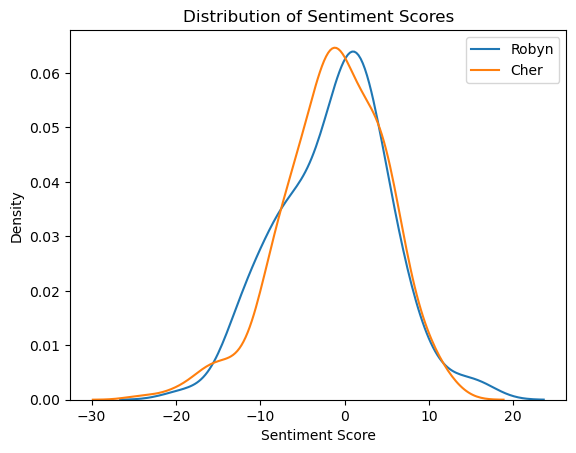

In [23]:
# Distribution of scores

# create separate dataframes for each artist
robyn_data = robyn_cher_data[robyn_cher_data['artist'] == 'robyn']
cher_data = robyn_cher_data[robyn_cher_data['artist'] == 'cher']

# plot density distributions using seaborn
sns.kdeplot(data=robyn_data['sentiment_score'], label='Robyn')
sns.kdeplot(data=cher_data['sentiment_score'], label='Cher')

# add axis labels and legend
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Scores')
plt.legend()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [39]:

# define positive and negative emojis and their corresponding scores
positive_emojis = ["\U0001F600", "\U0001F601", "\U0001F602", "\U0001F603", "\U0001F604", "\U0001F605", "\U0001F606", "\U0001F609", "\U0001F60A", "\U0001F60B", "\U0001F60C", "\U0001F60D", "\U0001F60E", "\U0001F60F", "\U0001F31F", "\U0001F917", "\U0001F918", "\U0001F970", "\U0001F929", "\U0001F496", "\U0001F495", "\U0001F497", "\U0001F499", "\U0001F49A", "\U0001F49B", "\U0001F49C", "\U0001F5A4", "\U0001F90E", "\U0001F49D", "\U0001F49E", "\U0001F49F", "\u2763", "\U0001F9E1"]
negative_emojis = ["\U0001F494", "\U0001F602", "\U0001F61E", "\U0001F620", "\U0001F625", "\U0001F629", "\U0001F62D", "\U0001F630", "\U0001F633", "\U0001F635", "\U0001F641", "\U0001F92C", "\U0001F912", "\U0001F915", "\U0001F922", "\U0001F92E", "\u2639", "\U0001F44E", "\U0001F615", "\U0001F616", "\U0001F621", "\U0001F626", "\U0001F627", "\U0001F628", "\U0001F62C", "\U0001F634", "\U0001F637", "\U0001F92F", "\U0001F9D0", "\U0001F910", "\U0001F611", "\U0001F622", "\U0001F62E", "\U0001F63F", "\U0001F92A", "\U0001F97A", "\U0001F92B", "\U0001F63E", "\U0001F64D", "\U0001F44A", "\U0001F480", "\U0001F4A9", "\U0001F595", "\U0001F64B"]


positive_score = 1
negative_score = -1



# filter the data to get only Cher and Robyn's followers
cher_followers = twitter_data[twitter_data['artist'] == 'cher']
robyn_followers = twitter_data[twitter_data['artist'] == 'robyn']

# define a function to calculate sentiment scores based on emojis
def calculate_sentiment_score(emojis, score):
    total_score = 0
    for emoji in emojis:
        total_score += twitter_data['description'].str.count(emoji).sum() * score
    return total_score

# calculate the sentiment scores for Cher and Robyn's followers
cher_sentiment_score = calculate_sentiment_score(positive_emojis, positive_score) + calculate_sentiment_score(negative_emojis, negative_score)
robyn_sentiment_score = calculate_sentiment_score(positive_emojis, positive_score) + calculate_sentiment_score(negative_emojis, negative_score)

# calculate the average sentiment scores for Cher and Robyn's followers
cher_average_sentiment = cher_sentiment_score / len(cher_followers)
robyn_average_sentiment = robyn_sentiment_score / len(robyn_followers)

print("Cher's average sentiment score: ", cher_average_sentiment)
print("Robyn's average sentiment score: ", robyn_average_sentiment)



Cher's average sentiment score:  0.0678070112753493
Robyn's average sentiment score:  0.7140195964932591


In [38]:
positive_emojis = ["\U0001F600", "\U0001F601", "\U0001F602", "\U0001F603", "\U0001F604", "\U0001F605", "\U0001F606", "\U0001F609", "\U0001F60A", "\U0001F60B", "\U0001F60C", "\U0001F60D", "\U0001F60E", "\U0001F60F", "\U0001F31F", "\U0001F917", "\U0001F918", "\U0001F970", "\U0001F929", "\U0001F496", "\U0001F495", "\U0001F497", "\U0001F499", "\U0001F49A", "\U0001F49B", "\U0001F49C", "\U0001F5A4", "\U0001F90E", "\U0001F49D", "\U0001F49E", "\U0001F49F", "\u2763", "\U0001F9E1"]
negative_emojis = ["\U0001F494", "\U0001F602", "\U0001F61E", "\U0001F620", "\U0001F625", "\U0001F629", "\U0001F62D", "\U0001F630", "\U0001F633", "\U0001F635", "\U0001F641", "\U0001F92C", "\U0001F912", "\U0001F915", "\U0001F922", "\U0001F92E", "\u2639", "\U0001F44E", "\U0001F615", "\U0001F616", "\U0001F621", "\U0001F626", "\U0001F627", "\U0001F628", "\U0001F62C", "\U0001F634", "\U0001F637", "\U0001F92F", "\U0001F9D0", "\U0001F910", "\U0001F611", "\U0001F622", "\U0001F62E", "\U0001F63F", "\U0001F92A", "\U0001F97A", "\U0001F92B", "\U0001F63E", "\U0001F64D", "\U0001F44A", "\U0001F480", "\U0001F4A9", "\U0001F595", "\U0001F64B"]

# Filter for each artist
cher_data = twitter_data[twitter_data['artist'] == 'cher']
robyn_data = twitter_data[twitter_data['artist'] == 'robyn']

# Define a function to count the number of positive and negative emojis in a string
def count_emojis(text):
    positive_count = 0
    negative_count = 0
    for char in text:
        if 'U+' in char:
            if char in positive_emojis:
                positive_count += 1
            elif char in negative_emojis:
                negative_count += 1
    return (positive_count, negative_count)

# Apply the function to each description and create new columns for positive and negative emoji counts
cher_data.loc[:, ['positive_emoji_count', 'negative_emoji_count']] = cher_data['description'].apply(lambda x: pd.Series(count_emojis(x)))
robyn_data.loc[:, ['positive_emoji_count', 'negative_emoji_count']] = robyn_data['description'].apply(lambda x: pd.Series(count_emojis(x)))

# Find the most popular positive and negative emoji for each artist
cher_most_popular_positive = max(positive_emojis, key=lambda x: cher_data[cher_data['description'].str.contains(x)]['positive_emoji_count'].sum())
cher_most_popular_negative = max(negative_emojis, key=lambda x: cher_data[cher_data['description'].str.contains(x)]['negative_emoji_count'].sum())
robyn_most_popular_positive = max(positive_emojis, key=lambda x: robyn_data[robyn_data['description'].str.contains(x)]['positive_emoji_count'].sum())
robyn_most_popular_negative = max(negative_emojis, key=lambda x: robyn_data[robyn_data['description'].str.contains(x)]['negative_emoji_count'].sum())

# Print the results
print('Cher most popular positive emoji:', cher_most_popular_positive)
print('Cher most popular negative emoji:', cher_most_popular_negative)
print('Robyn most popular positive emoji:', robyn_most_popular_positive)
print('Robyn most popular negative emoji:', robyn_most_popular_negative)



/var/folders/5b/b9cxhv4n4t90drzfsj1kdbx00000gp/T/ipykernel_81719/3901491419.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cher_data.loc[:, ['positive_emoji_count', 'negative_emoji_count']] = cher_data['description'].apply(lambda x: pd.Series(count_emojis(x)))
/var/folders/5b/b9cxhv4n4t90drzfsj1kdbx00000gp/T/ipykernel_81719/3901491419.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  robyn_data.loc[:, ['positive_emoji_count', 'negative_emoji_count']] = robyn_data['description'].apply(lambda x: pd.S

Cher most popular positive emoji: 😀
Cher most popular negative emoji: 💔
Robyn most popular positive emoji: 😀
Robyn most popular negative emoji: 💔


Q: What is the average sentiment of your two artists? 

A: Average score is calculated by taking the sentiment score of the artist and dividing it by the # of followers. 
- Cher's average sentiment score:  0.0678
- Robyn's average sentiment score:  0.714

Robyn's emoji sentiment score is comparatively higher. The lower sentiment score can be attributed to the omission of several emoji codes that were not included in the analysis. To obtain a more accurate and reliable score, it is recommended to use a larger and more comprehensive list of the most commonly used emojis. The current list used in the code was a randomly selected assortment of both positive and negative emojis.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: 
- Cher most popular positive emoji: 😀
- Cher most popular negative emoji: 💔
- Robyn most popular positive emoji: 😀
- Robyn most popular negative emoji: 💔

Given the limited range of emojis considered and the considerable following of both artists, it is conceivable that they share the same most popular positive and negative emojis. However, expanding the pool of considered emojis is likely to yield distinct outcomes. Nonetheless, it should be noted that the positive and negative emojis in question are widely used, and hence, there remains a possibility that even an enlarged list of emojis may not alter the observed results.
